# Random forests

Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor.

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fastbook import (
    Path,
    URLs,
    load_pickle,
)
from sklearn.ensemble import RandomForestRegressor

from evaluation import m_rmse, r_mse

### Load dataset

In [7]:
path = Path('/home/david/.fastai/archive/bluebook-for-bulldozers')
path

Path('.')

In [11]:
Path.BASE_PATH = path
path.ls(file_type='text')

(#7) [Path('TrainAndValid.csv'),Path('Machine_Appendix.csv'),Path('Valid.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('random_forest_benchmark_test.csv'),Path('median_benchmark.csv')]

In [13]:
to = load_pickle(path / "to.pkl")

xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [14]:
# additional pre-processing

xs.loc[xs["YearMade"] < 1900, "YearMade"] = 1950
valid_xs.loc[valid_xs["YearMade"] < 1900, "YearMade"] = 1950

In [15]:
type(xs), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

### Creating a random forest

In [18]:
# we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel.

def random_forest(
    xs: pd.DataFrame,
    y: pd.Series,
    n_estimators: int = 40,
    max_samples: int = 200_000,
    max_features: float = 0.5,
    min_samples_leaf: int = 5,
    **kwargs
):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True
    ).fit(xs, y)

In [20]:
model = random_forest(xs, y)

m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y)

(0.17087, 0.232547)

A better result compared to decision tree results (0.251824, 0.322255).

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as max_features.

To see the impact of n_estimators, let's get the predictions from each individual tree in our forest (these are in the `estimators_` attribute):

In [23]:
preds = np.stack([t.predict(valid_xs) for t in model.estimators_])

# the same result as before
r_mse(preds.mean(0), valid_y)

/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/david/anaconda3/envs/fas

0.232547

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

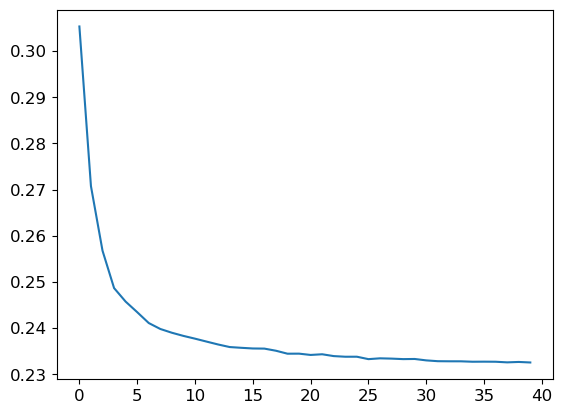

In [25]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])



The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error that can help us with this.

### Out-of-bag-error

Intuition: Since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.


 The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training.

 This is particularly beneficial in cases where we have only a small amount of training data.

In [26]:
r_mse(model.oob_prediction_, y)

0.210671

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in addition to normal generalization error.